# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from susceptibility_scores import construct_paths_and_dataset_kwargs

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "YagoECQ"
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"
SEED = 0
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 500
MAX_ENTITIES = 100
CAP_PER_TYPE = False
ABLATE_OUT_RELEVANT_CONTEXTS = False
OVERWRITE = True
ENTITY_TYPES = ["entities", "fake_entities"]
QUERY_TYPES = ["closed", "open"]

# Model parameters
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

In [4]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)
QUERY_IDS = list(yago_qec.keys())
QUERY_ID = QUERY_IDS[0]
SUBNAME = f"{extract_name_from_yago_uri(QUERY_ID)[0]}_{extract_name_from_yago_uri(QUERY_ID)[1]}"
QUERY_IDS[:5], len(QUERY_IDS)

(['http://schema.org/alumniOf',
  'http://schema.org/duration',
  'reverse-http://schema.org/director',
  'http://schema.org/address',
  'http://schema.org/duns'],
 56)

In [5]:
# Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    answers_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID=QUERY_ID,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    OVERWRITE=OVERWRITE,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
)

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [6]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ


In [7]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

Overwriting datasets (if they already exist) at data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0/inputs/entities.json, data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0/inputs/answers.json, data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0/inputs/contexts.json, and data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0/inputs/queries.json.


In [8]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [9]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 0, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'OVERWRITE': True, 'ENTITY_TYPES': ['entities', 'fake_entities'], 'QUERY_TYPES': ['closed', 'open'], 'BATCH_SZ': 16, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['yago', 'analysis'], 'LOG_DATASETS': True, 'QUERY_IDS': ['http://schema.org/alumniOf', 'http://schema.org/duration', 'reverse-http://schema.org/director', 'http://schema.org/address', 'http://schema.org/duns', 'http://schema.org/founder', 'http://schema.org/elevation', 'reverse-http://schema.org/editor', 'http://schema.org/lyricist', 'http://schema.org/memberOf', 'http://schema.org/about', 'http://schema.org/gtin', 'http://schema.org/administrates', 'http://schema.org/leader', 'http://schema.org/illustrator', 'http://schema.org/material', 'http://schema.o

### Load Data

In [11]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path,
    index_col=0,
    converters={"contexts": literal_eval, "entity": literal_eval},
)

In [12]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed_open/0/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2b01776a7af0>.


### Analyze Data

In [13]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,answer,contexts,susceptibility_score,full_query_example
0,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,0.021975,Israel Zolli is an alum of McGill University F...
1,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Q. Allan Brocka,)",Washington High School,[Israel Zolli is an alum of McGill University ...,0.021293,Israel Zolli is an alum of McGill University F...
2,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(S.F. Claus,)",Lycée Louis-le-Grand,[Israel Zolli is an alum of McGill University ...,0.021159,Israel Zolli is an alum of McGill University F...
3,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Morris of Aquitaine,)",Nottingham High School,[Israel Zolli is an alum of McGill University ...,0.028256,Israel Zolli is an alum of McGill University F...
4,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Sylvester Hicks,)",North Side High School,[Israel Zolli is an alum of McGill University ...,0.020629,Israel Zolli is an alum of McGill University F...


In [14]:
val_df_contexts_per_qe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q_id                  400 non-null    object 
 1   query_form            400 non-null    object 
 2   entity                400 non-null    object 
 3   answer                400 non-null    object 
 4   contexts              400 non-null    object 
 5   susceptibility_score  400 non-null    float64
 6   full_query_example    400 non-null    object 
dtypes: float64(1), object(6)
memory usage: 25.0+ KB


In [15]:
val_df_contexts_per_qe["entity"].value_counts()

(Margaret Thatcher,)                           4
(Michael Martin,)                              4
(Leonard Beers,)                               4
(Conapa Penzianoti,)                           4
(Carles Magraner,)                             4
                                              ..
(John S. Traill,)                              4
(Campbell,)                                    4
(List of members of the Battle of Alameda,)    4
(Dougal Dixon,)                                4
(Jason Koon,)                                  4
Name: entity, Length: 100, dtype: int64

In [16]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Israel Zolli is an alum of McGill University Faculty of Law.\n',
 "Denny O'Brien is an alum of Uppsala University.\n",
 'Peter McLaughlin is an alum of University of Toronto.\n',
 'Jay Brira is an alum of Yale Law School.\n',
 'Conapa Penzianoti is an alum of Johns Hopkins Bloomberg School of Public Health.\n',
 'Carl Georg With is an alum of University of Minnesota Law School.\n',
 'John Passmore is an alum of Niles West High School.\n',
 'Campbell is an alum of Université de Moncton.\n',
 'Jason Koon is an alum of LaGrange High School.\n',
 'Vitti Meriter is an alum of University of New Mexico.\n']

In [17]:
# import re

# p = r"of\s(.*?)(?=\sis\b)"
# c_ents = [
#     re.search(p, text).group(1) for text in val_df_contexts_per_qe.iloc[0]["contexts"]
# ]
# ents = val_df_contexts_per_qe["entity"].tolist()
# if (
#     DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
#     and len(set(c_ents).intersection(set(ents))) != 0
# ):
#     raise ValueError(
#         "ablate_out_relevant_contexts is True, but the contexts contain entities in the entities list."
#     )

In [18]:
entities_df = pd.DataFrame(
    {k: v for k, v in yago_qec[QUERY_ID].items() if k in {"entities", "fake_entities"}}
)
real_ents = set(entities_df["entities"])
fake_ents = set(entities_df["fake_entities"])
print("# unique real ents:", len(real_ents))
print("# unique fake ents:", len(fake_ents))
print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
print("Overlapping ents:", real_ents.intersection(fake_ents))
entities_df["entities"].value_counts(), entities_df["fake_entities"].value_counts()

# unique real ents: 999
# unique fake ents: 984
# overlapping ents: 0
Overlapping ents: set()


(Jonathan Powell       2
 Phil Fortunato        1
 Georgios Roilos       1
 Zeno Payne Metcalf    1
 Chris Heaphy          1
                      ..
 Barton Lynch          1
 Lee Young-jin         1
 Paul Girolami         1
 Charles Oxenden       1
 Charles Moseley       1
 Name: entities, Length: 999, dtype: int64,
 Adam and Eve                                         4
 Abraham                                              3
 Margaret Thatcher                                    3
 Adolf Hitler                                         3
 Bobby Bobby                                          2
                                                     ..
 Melchert Baywell                                     1
 Andrey Tharpe                                        1
 Walter Clayford, 1st Viscount Clayford of Angfall    1
 Inau Hill                                            1
 Robert Bruce                                         1
 Name: fake_entities, Length: 984, dtype: int64)

In [19]:
entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
print(entities_df_tidy.head())
entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
entities_df_tidy.head()
entities_df_tidy.info()

       type           entity
0  entities   Phil Fortunato
1  entities   Tuomas Knowles
2  entities     David Rimoin
3  entities  Bruce Dalrymple
4  entities  Zach Charbonnet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    2000 non-null   object
 1   entity  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [27]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    entities_df_tidy,
    left_on="entity",
    right_on="entity",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "contexts",
        "type",
        "susceptibility_score",
    ]
]
val_df_per_qe

,q_id,query_form,entity,answer,contexts,type,susceptibility_score
0,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021975
1,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021975
2,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021975
3,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Q. Allan Brocka,)",Washington High School,[Israel Zolli is an alum of McGill University ...,entities,0.021293
4,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(S.F. Claus,)",Lycée Louis-le-Grand,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021159
...,...,...,...,...,...,...,...
403,http://schema.org/alumniOf,{entity} is an alum of,"(Georges de Luna,)",University of Glasgow,[Israel Zolli is an alum of McGill University ...,fake_entities,0.860247
404,http://schema.org/alumniOf,{entity} is an alum of,"(C. O'Conor Goolrick,)",University of Virginia School of Law,[Israel Zolli is an alum of McGill University ...,entities,0.861290
405,http://schema.org/alumniOf,{entity} is an alum of,"(Permanata,)",American University,[Israel Zolli is an alum of McGill University ...,fake_entities,0.739599
406,http://schema.org/alumniOf,{entity} is an alum of,"(Dr. Dre,)",Rollins College,[Israel Zolli is an alum of McGill University ...,fake_entities,0.429974


In [28]:
query_forms = val_df_per_qe["query_form"].unique()
query_forms

array(['Q: Is {entity} an alum of {answer}?\nA:',
       'Q: Does {answer} count {entity} as one of its alumni?\nA:',
       'Q: Which institution or organization is {entity} an alum of?\nA:',
       '{entity} is an alum of'], dtype=object)

In [29]:
closed_qfs = yago_qec[QUERY_ID]["query_forms"]["closed"]
open_qfs = yago_qec[QUERY_ID]["query_forms"]["open"]

val_df_per_qe.loc[val_df_per_qe["query_form"].isin(closed_qfs), "query_type"] = "closed"
val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"
val_df_per_qe

,q_id,query_form,entity,answer,contexts,type,susceptibility_score,query_type
0,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021975,closed
1,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021975,closed
2,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",University of Chicago,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021975,closed
3,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Q. Allan Brocka,)",Washington High School,[Israel Zolli is an alum of McGill University ...,entities,0.021293,closed
4,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(S.F. Claus,)",Lycée Louis-le-Grand,[Israel Zolli is an alum of McGill University ...,fake_entities,0.021159,closed
...,...,...,...,...,...,...,...,...
403,http://schema.org/alumniOf,{entity} is an alum of,"(Georges de Luna,)",University of Glasgow,[Israel Zolli is an alum of McGill University ...,fake_entities,0.860247,open
404,http://schema.org/alumniOf,{entity} is an alum of,"(C. O'Conor Goolrick,)",University of Virginia School of Law,[Israel Zolli is an alum of McGill University ...,entities,0.861290,open
405,http://schema.org/alumniOf,{entity} is an alum of,"(Permanata,)",American University,[Israel Zolli is an alum of McGill University ...,fake_entities,0.739599,open
406,http://schema.org/alumniOf,{entity} is an alum of,"(Dr. Dre,)",Rollins College,[Israel Zolli is an alum of McGill University ...,fake_entities,0.429974,open


In [30]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

,q_id,query_form,entity,answer,contexts,type,susceptibility_score,query_type
89,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Edwin A. Andrews,)",University of Music and Performing Arts Vienna,[Israel Zolli is an alum of McGill University ...,fake_entities,0.017615,closed
32,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(John S. Traill,)",University of Toronto,[Israel Zolli is an alum of McGill University ...,entities,0.017998,closed
29,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Dougal Dixon,)",University of St Andrews,[Israel Zolli is an alum of McGill University ...,entities,0.018230,closed
23,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Walter Salles,)",University of Southern California,[Israel Zolli is an alum of McGill University ...,entities,0.018315,closed
37,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Don R. Lettington,)",Hamilton College,[Israel Zolli is an alum of McGill University ...,fake_entities,0.018488,closed
...,...,...,...,...,...,...,...,...
74,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Conapa Penzianoti,)",University of Michigan,[Israel Zolli is an alum of McGill University ...,fake_entities,0.039574,closed
10,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Baton, Davis,)",University of Melbourne,[Israel Zolli is an alum of McGill University ...,fake_entities,0.039779,closed
31,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Campbell,)",Sapienza University of Rome,[Israel Zolli is an alum of McGill University ...,fake_entities,0.042515,closed
56,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Vitti Meriter,)",Ankara University,[Israel Zolli is an alum of McGill University ...,fake_entities,0.042659,closed


In [31]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]][
    ["entity", "type", "susceptibility_score"]
].sort_values(by="susceptibility_score")

,entity,type,susceptibility_score
89,"(Edwin A. Andrews,)",fake_entities,0.017615
32,"(John S. Traill,)",entities,0.017998
29,"(Dougal Dixon,)",entities,0.018230
23,"(Walter Salles,)",entities,0.018315
37,"(Don R. Lettington,)",fake_entities,0.018488
...,...,...,...
74,"(Conapa Penzianoti,)",fake_entities,0.039574
10,"(Baton, Davis,)",fake_entities,0.039779
31,"(Campbell,)",fake_entities,0.042515
56,"(Vitti Meriter,)",fake_entities,0.042659


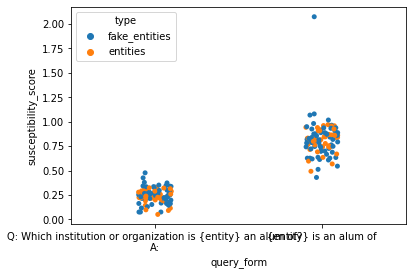

In [32]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_type"] == "open"],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plot_name = f"plot_susscore_vs_queryform_real_fake_{SUBNAME}"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

<AxesSubplot:xlabel='entity_mentions_in_contexts', ylabel='susceptibility_score'>

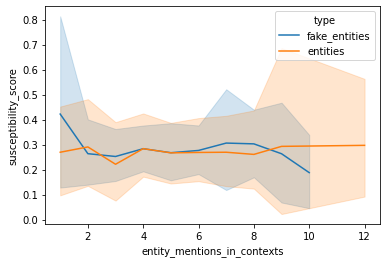

In [35]:
val_df_per_qe["entity_mentions_in_contexts"] = val_df_per_qe.apply(
    lambda row: sum([row["entity"][0] in context for context in row["contexts"]]),
    axis=1,
)
sns.lineplot(
    data=val_df_per_qe,
    x="entity_mentions_in_contexts",
    y="susceptibility_score",
    hue="type",
)
# val_df_per_qe

In [34]:
def construct_df_given_query_id(query_id: List[str], verbose=True):
    # Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
    (
        data_dir,
        input_dir,
        entities_path,
        contexts_path,
        queries_path,
        answers_path,
        val_data_path,
        model_dir,
        results_dir,
        val_results_path,
        data_id,
        model_id,
        DATASET_KWARGS_IDENTIFIABLE,
    ) = construct_paths_and_dataset_kwargs(
        DATASET_NAME=DATASET_NAME,
        RAW_DATA_PATH=RAW_DATA_PATH,
        SEED=SEED,
        MODEL_ID=MODEL_ID,
        LOAD_IN_8BIT=LOAD_IN_8BIT,
        QUERY_ID=query_id,
        MAX_CONTEXTS=MAX_CONTEXTS,
        MAX_ENTITIES=MAX_ENTITIES,
        CAP_PER_TYPE=CAP_PER_TYPE,
        ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
        OVERWRITE=OVERWRITE,
        ENTITY_TYPES=ENTITY_TYPES,
        QUERY_TYPES=QUERY_TYPES,
    )
    # Analysis dir
    analysis_dir = os.path.join(data_dir, "analysis")
    if verbose:
        print(f"Analysis dir: {analysis_dir}")
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)

    # Set random seeds
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    from ast import literal_eval

    try:
        val_df_contexts_per_qe = pd.read_csv(
            val_results_path,
            index_col=0,
            converters={"contexts": literal_eval, "entity": literal_eval},
        )
    except FileNotFoundError as e:
        print(f"Unable to find file at {val_results_path}, full error: {e}")
        return None
    if verbose:
        print("val_df_contexts_per_qe info:")
        print(val_df_contexts_per_qe.info())
        print(val_df_contexts_per_qe["entity"].value_counts())
        print(val_df_contexts_per_qe.iloc[0]["contexts"][:10])
        print("Entities info:")
    entities_df = pd.DataFrame(
        {
            k: v
            for k, v in yago_qec[query_id].items()
            if k in {"entities", "fake_entities"}
        }
    )
    real_ents = set(entities_df["entities"])
    fake_ents = set(entities_df["fake_entities"])

    entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
    entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
    if verbose:
        print("# unique real ents:", len(real_ents))
        print("# unique fake ents:", len(fake_ents))
        print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
        print("Overlapping ents:", real_ents.intersection(fake_ents))
        print(
            entities_df["entities"].value_counts(),
            entities_df["fake_entities"].value_counts(),
        )
        print(entities_df_tidy.head())
        print(entities_df_tidy.info())

    val_df_per_qe = val_df_contexts_per_qe.merge(
        entities_df_tidy,
        left_on="entity",
        right_on="entity",
        how="left",
    )[
        [
            "q_id",
            "query_form",
            "entity",
            "answer",
            "contexts",
            "type",
            "susceptibility_score",
        ]
    ]
    query_forms = val_df_per_qe["query_form"].unique()
    closed_qfs = yago_qec[query_id]["query_forms"]["closed"]
    open_qfs = yago_qec[query_id]["query_forms"]["open"]

    val_df_per_qe.loc[
        val_df_per_qe["query_form"].isin(closed_qfs), "query_type"
    ] = "closed"
    val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"

    if verbose:
        print("val_df_per_qe info:")
        print(val_df_per_qe)

        print(f"query forms: {query_forms}")
        print(
            "Sorted sus scores:",
            val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
                by="susceptibility_score"
            ),
        )

    return val_df_per_qe

In [ ]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(query_id, verbose=False)
    for query_id in QUERY_IDS
}

In [ ]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

In [ ]:
import math

num_plots = len(qid_to_val_df_per_qe)
num_cols = 3
num_rows = math.ceil(num_plots // 3) + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(16, 100))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    row = math.ceil(count // num_cols)
    col = count % num_cols
    ax = axes[row][col]
    sns.stripplot(
        data=df,
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        # hue="is_real",
        # dodge=True
        # jitter=0.1,
        # legend="full",
    )
    subname = (
        f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
    )
    ax.set_title(subname)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
    count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
import math

num_rows = len(qid_to_val_df_per_qe)
num_cols = 2
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(8, 250))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    for qt in ["closed", "open"]:
        row = math.ceil(count // num_cols)
        col = count % num_cols
        ax = axes[row][col]
        sns.stripplot(
            data=df[df["query_type"] == qt],
            x="query_form",
            y="susceptibility_score",
            hue="type",
            ax=ax,
            # hue="is_real",
            # dodge=True
            # jitter=0.1,
            # legend="full",
        )
        subname = (
            f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
        )
        ax.set_title(subname)
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)
        count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all_open_vs_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
from scipy.stats import ttest_ind


def ttest(df):
    sus_scores_real = df[df["type"] == "entities"]["susceptibility_score"]
    sus_scores_fake = df[df["type"] == "fake_entities"]["susceptibility_score"]
    ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    ttest_res = ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    t_stat, p_value = ttest_res.statistic, ttest_res.pvalue
    # print(t_stat, p_value)
    cohen_d = t_stat * np.sqrt(
        (len(sus_scores_real) + len(sus_scores_fake))
        / (len(sus_scores_real) * len(sus_scores_fake))
    )
    cohen_d2 = (np.mean(sus_scores_real) - np.mean(sus_scores_fake)) / np.sqrt(
        (
            np.var(sus_scores_real, ddof=1) * (len(sus_scores_real) - 1)
            + np.var(sus_scores_fake, ddof=1) * (len(sus_scores_fake) - 1)
        )
        / (len(sus_scores_real) + len(sus_scores_fake) - 2)
    )
    assert np.isclose(cohen_d, cohen_d2)
    # effect_size,
    return {
        "effect_size": cohen_d,
        "p_value": p_value,
        "n": len(sus_scores_fake) + len(sus_scores_real),
    }


# ttest_scores = [{"query": k, **ttest(v)} for k, v in qid_to_val_df_per_qe.items()]
ttest_scores = [
    {"query": k, **ttest(v[v["query_type"] == "closed"])}
    for k, v in qid_to_val_df_per_qe.items()
]
# ttest_scores = [{"query": k, **ttest(v[v["query_type"] == "open"])} for k, v in qid_to_val_df_per_qe.items()]

pd.DataFrame(ttest_scores).sort_values(by="p_value").reset_index(drop=True)

### Examining model outputs

In [ ]:
# TODO: (1) try answer_map thing, and also (2) randomly sample so that each entity shows up in contexts evenly

In [ ]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [ ]:
def print_top_k_next_token_probs(
    model, tokenizer, query, entity, context, answer=None, k=50
):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(
                    query=query, entity=entity, context=context, answer=answer
                ),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [ ]:
val_df_contexts_per_qe.info(), val_df_per_qe.info()

In [ ]:
val_df_per_qe.drop(
    columns=["contexts", "type", "q_id", "entity_mentions_in_contexts"]
).value_counts()

In [ ]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

In [ ]:
entity_to_context_mentions = {
    entity: sum([entity[0] in context for context in val_df_per_qe.iloc[0]["contexts"]])
    for entity in val_df_per_qe["entity"].unique()
}
entity_to_context_mentions = dict(
    sorted(entity_to_context_mentions.items(), key=lambda x: x[1])
)
print("Number of contexts each entity is mentioned in:")
entity_to_context_mentions

In [ ]:
pp = pprint.PrettyPrinter()
query_id = "reverse-http://schema.org/manufacturer"
val_df_per_qe = qid_to_val_df_per_qe[query_id]
# print(val_df_per_qe)
row = (
    val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]]
    .sort_values(by="susceptibility_score")
    .iloc[0]
)
entity = row["entity"]
answer = row["answer"]
print("entity:", entity)
contexts = row["contexts"]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context="", answer=answer))
print(
    "CMI:",
    estimate_cmi(query, entity, contexts, model, tokenizer, answer_entity=answer),
)

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(
    model, tokenizer, query, entity, context="", k=50, answer=answer
)
print("\n\n")
print("Top-k next token probs WITH context mentioning entity")
for context in contexts:
    if entity[0] in context:
        print(
            f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
        )
        print_top_k_next_token_probs(
            model, tokenizer, query, entity, context, k=50, answer=answer
        )
        print("\n\n")
print("\n\n")
print("Top-k next token probs WITH context NOT mentioning entity")
for context in contexts[:5]:
    print(
        f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
    )
    print_top_k_next_token_probs(
        model, tokenizer, query, entity, context, k=50, answer=answer
    )
    print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context="", answer=answer),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

In [ ]:
tokenizer([" Nope"])

### Correlation with Pile frequency

In [ ]:
unigram_frequencies = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-unigrams.bin",
    dtype=np.int64,
    mode="r",
    shape=(50277,),
)
view = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia_pile_idxmaps/pile_0.87_deduped_text_document.bin",
    dtype=np.uint16,
    mode="r",
)

In [ ]:
import zstandard as zstd
import pickle
from scipy.sparse import load_npz

file_path = (
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-deduped-bigrams.zst"
)
# # Open the zstd file for reading in binary mode
# with open(file_path, 'rb') as compressed_file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(compressed_file) as reader:
#         # Decompress the zstd file and load the pickled data
#         pickled_data = pickle.loads(reader.read())

# Reconstruct the SciPy sparse array
# sparse_array = load_npz(pickled_data)

with open(file_path, "rb") as f:
    data = f.read()

dctx = zstd.ZstdDecompressor()
decompressed = dctx.decompress(data)
pickled_scipy = pickle.loads(decompressed)

In [ ]:
len(decompressed), type(decompressed), decompressed[:5]

In [ ]:
entities = val_df_contexts_per_qe["entity"].apply(lambda x: x[0]).unique().tolist()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)
tokenized_entities = [tuple(e) for e in tokenizer(entities)["input_ids"]]
tokenized_entities_prespace = [
    tuple(e) for e in tokenizer([" " + e for e in entities])["input_ids"]
]
tokenized_entities
tokenized_entities_prespace
entities_to_freqs = {
    e: {tokenized_entities[i]: 0, tokenized_entities_prespace[i]: 0}
    for i, e in enumerate(entities)
}
entities_to_freqs["Zimbabwe"]

# tokenized_entities
# {
#     entity:
#         {
#             tokens_without_space: count,
#             tokens_with_space: count
#         }
# }

In [ ]:
# relevant_token_seqs = set(tokenized_entities + tokenized_entities_prespace)
relevant_token_seqs = set(tokenized_entities_prespace)
relevant_token_seqs

In [ ]:
from collections import Counter

unigram_tokens = {
    t: unigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 1
}
unigram_tokens

In [ ]:
bigram_tokens = {
    t: bigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 2
}

In [ ]:
for e, freq_dicts in entities_to_freqs.items():
    total = 0
    for token_seqs in freq_dicts.keys():
        if len(token_seqs) == 1:
            freq_dicts[token_seqs] = unigram_frequencies[token_seqs[0]]
        if len(token_seqs) == 2:
            freq_dicts[token_seqs] = bigram_frequencies[token_seqs]
        total += freq_dicts[token_seqs]
    freq_dicts["total"] = total

In [ ]:
entities_to_freqs

In [ ]:
entity_counts = dict(
    sorted(
        {
            (k,): v["total"] for k, v in entities_to_freqs.items() if v["total"] != 0
        }.items(),
        key=lambda x: x[1],
    )
)
ent_freq_df = pd.DataFrame(
    list(entity_counts.items()), columns=["entity", "ent_frequency"]
)
ent_freq_df

In [ ]:
val_df_per_qe_with_freq = val_df_per_qe.merge(ent_freq_df)
val_df_per_qe_with_freq["log_ent_frequency"] = val_df_per_qe_with_freq[
    "ent_frequency"
].apply(np.log)
val_df_per_qe_with_freq

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df = val_df_per_qe_with_freq[val_df_per_qe_with_freq["query_form"] == query_forms[0]]
plot = sns.regplot(
    data=df,
    x="log_ent_frequency",
    y="susceptibility_score",
    # logx=True,
    # hue="query_form",
    ax=ax,
    label=True,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

for i, row in df.iterrows():
    ax.text(
        row["log_ent_frequency"],
        row["susceptibility_score"],
        row["entity"],
        ha="right",
        va="bottom",
    )

plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic_ent_frequency"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# 24000 min = 2+ weeks of CPU hours to finish lmao
from tqdm.auto import trange
CHUNK_SIZE = 50_000_000
VOCAB_SIZE = 50_277
window_size = 1
for i in trange(0, len(view), CHUNK_SIZE):
    chunk = view[i : i + CHUNK_SIZE]
    for j in trange(len(chunk) - (window_size - 1)):
        ngram = tuple(chunk[j: j+window_size])
        if ngram in unigram_tokens:
            unigram_tokens[ngram] += 1        
    # counts += np.bincount(chunk, minlength=len(counts))

In [ ]:
unigram_frequencies

In [ ]:
tokenizer.convert_ids_to_tokens([38581])

In [ ]:
wandb.finish()